# EDA multi-saisons pour Machine Learning

## 1. Chargement de toutes les saisons (2014–2024)

In [17]:
import pandas as pd
from pathlib import Path

# Chemins
base = Path("../data/curated/")
seasons = [f"{y}-{str(y+1)[-2:]}" for y in range(2014, 2024)]

# Charger le fichier des scores
scores = pd.read_parquet(base / "all_seasons_scores.parquet")

# Charger toutes les saisons pour les features
dfs = []
for s in seasons:
    df = pd.read_parquet(base / f"player_season_{s}.parquet")
    df["season"] = s
    dfs.append(df)

features = pd.concat(dfs, ignore_index=True)

# Fusion des scores + features
df_all = pd.merge(scores, features, on=["PLAYER_ID", "season"], how="left")
df_all["avail"] = df_all["gp"] / 82
df_all.shape


(5312, 14)

## 2. Valeurs manquantes globales

In [8]:
df_all.isna().mean().sort_values(ascending=False) * 100

PLAYER_NAME        48.606928
height_cm           9.167922
weight_kg           9.167922
bmi                 9.167922
age                 9.167922
PLAYER_ID           0.000000
score_100           0.000000
season              0.000000
pts_mean            0.000000
reb_mean            0.000000
ast_mean            0.000000
plus_minus_mean     0.000000
gp                  0.000000
dtype: float64

## 3. Évolution temporelle de pts_mean

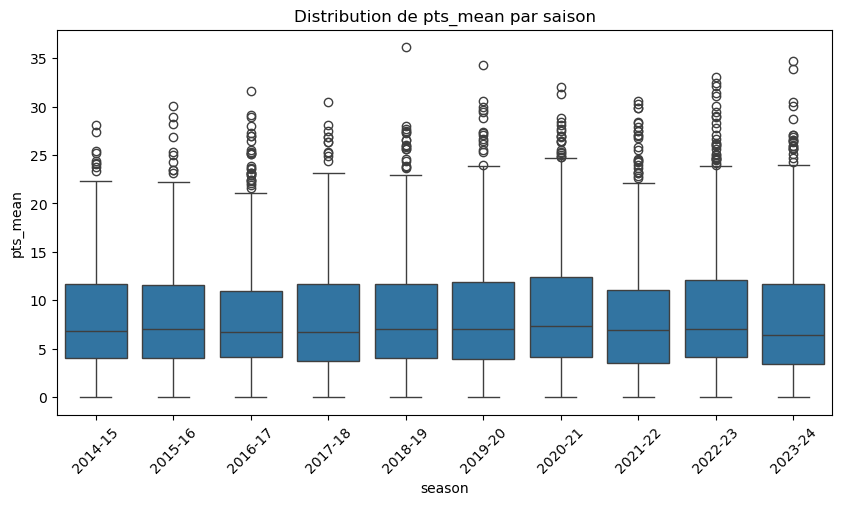

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(data=df_all, x='season', y='pts_mean')
plt.title("Distribution de pts_mean par saison")
plt.xticks(rotation=45)
plt.show()

## 4. Corrélations globales

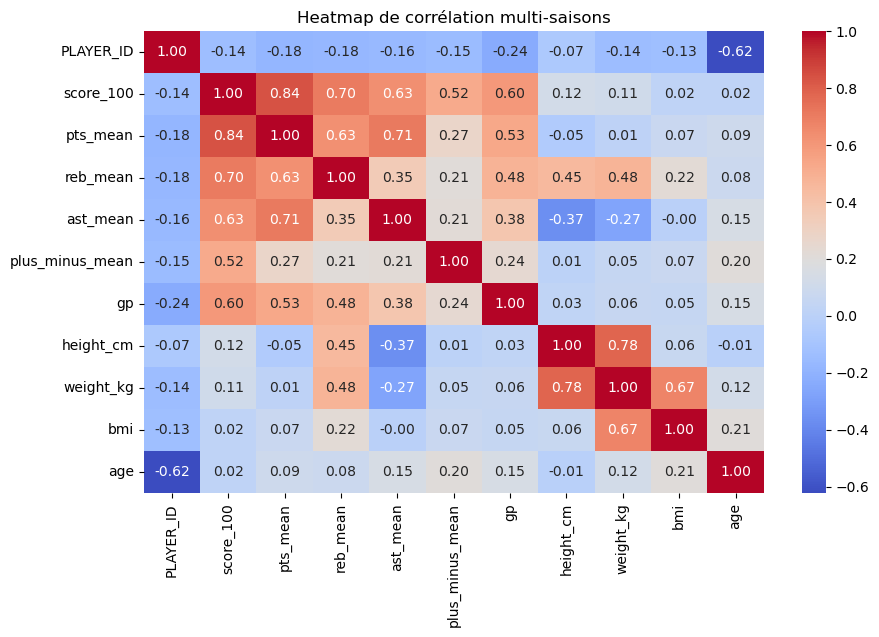

In [10]:
plt.figure(figsize=(10,6))
sns.heatmap(df_all.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de corrélation multi-saisons")
plt.show()

## 5. Préparation du jeu ML : note_n → note_n+1

In [11]:
df_all = df_all.sort_values(["PLAYER_ID", "season"])
df_all["note_n"] = df_all["score_100"]
df_all["note_n1"] = df_all.groupby("PLAYER_ID")["score_100"].shift(-1)

# Seulement les lignes avec une target disponible
ml_df = df_all.dropna(subset=["note_n1"])
ml_df[["PLAYER_ID", "season", "note_n", "note_n1"]].head()

,PLAYER_ID,season,note_n,note_n1
0,708,2014-15,43.527314,28.137502
1,977,2014-15,55.723842,32.253009
2,1495,2014-15,69.248446,52.567783
3,1713,2014-15,36.042404,24.324586
495,1713,2015-16,24.324586,33.794650


## 6. Corrélation entre saison n et saison n+1

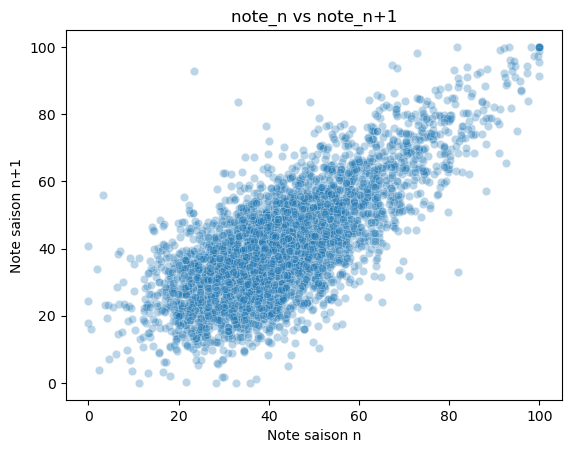

In [12]:
sns.scatterplot(data=ml_df, x="note_n", y="note_n1", alpha=0.3)
plt.title("note_n vs note_n+1")
plt.xlabel("Note saison n")
plt.ylabel("Note saison n+1")
plt.show()

## 7. Conclusion

- Variables les plus stables : `pts_mean`, `reb_mean`, `avail`, `age`
- Corrélation forte entre note_n et note_n+1 ➜ bon candidat pour prédiction
- Prochaine étape : préparer X / y pour entraîner un modèle prédictif.

## 8. Variabilité inter-joueurs (constance vs irrégularité)

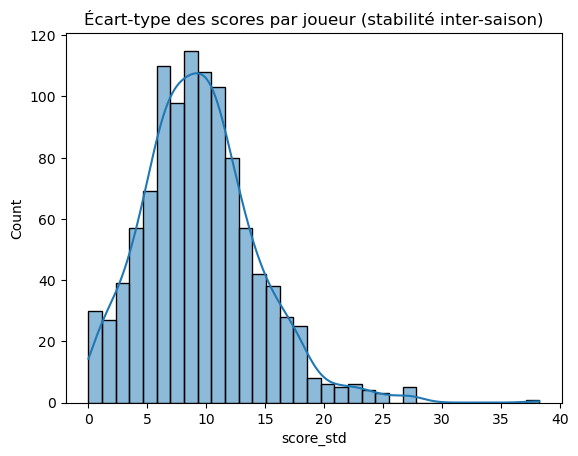

In [13]:
df_std = df_all.groupby("PLAYER_ID")["score_100"].std().reset_index()
df_std.columns = ["PLAYER_ID", "score_std"]
sns.histplot(df_std["score_std"], kde=True)
plt.title("Écart-type des scores par joueur (stabilité inter-saison)")
plt.show()

## 9. Exemple de trajectoire individuelle

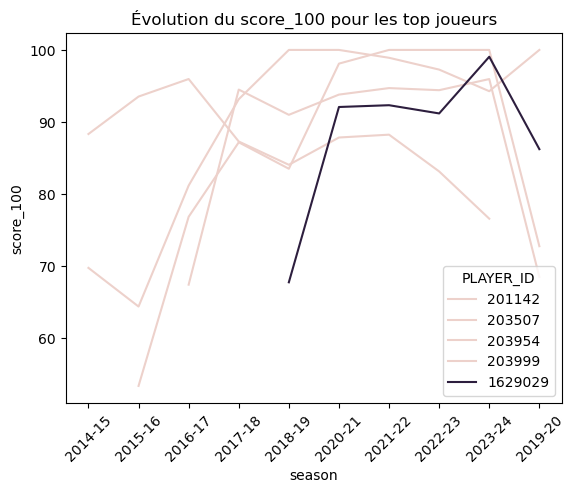

In [14]:
top_players = df_all.groupby("PLAYER_ID")["score_100"].mean().sort_values(ascending=False).head(5).index.tolist()
df_top = df_all[df_all["PLAYER_ID"].isin(top_players)]
sns.lineplot(data=df_top, x="season", y="score_100", hue="PLAYER_ID")
plt.title("Évolution du score_100 pour les top joueurs")
plt.xticks(rotation=45)
plt.show()

## 10. Stats moyennes par tranche d'âge

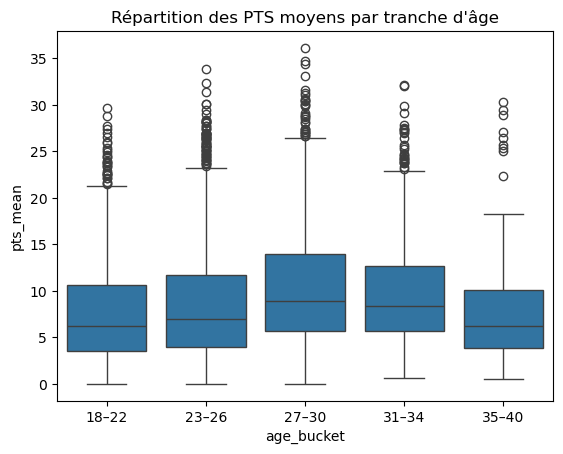

In [15]:
df_all['age_bucket'] = pd.cut(df_all['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18–22","23–26","27–30","31–34","35–40"])
sns.boxplot(data=df_all, x="age_bucket", y="pts_mean")
plt.title("Répartition des PTS moyens par tranche d'âge")
plt.show()

## 11. t-SNE pour visualiser les types de profils joueurs

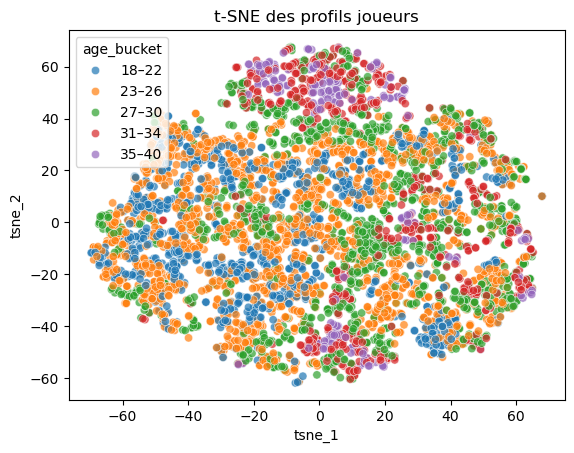

In [19]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

features = ["pts_mean", "reb_mean", "ast_mean", "plus_minus_mean", "avail", "height_cm", "bmi", "age"]
df_visu = df_all.dropna(subset=features).copy()
# Create age_bucket in df_visu similar to how it was created earlier
df_visu['age_bucket'] = pd.cut(df_visu['age'], bins=[18, 22, 26, 30, 34, 40], labels=["18–22","23–26","27–30","31–34","35–40"])

X = StandardScaler().fit_transform(df_visu[features])

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
df_visu["tsne_1"], df_visu["tsne_2"] = zip(*tsne.fit_transform(X))
sns.scatterplot(data=df_visu, x="tsne_1", y="tsne_2", hue="age_bucket", alpha=0.7)
plt.title("t-SNE des profils joueurs")
plt.show()

## 🔍 Visualisation t‑SNE des profils joueurs

Nous avons projeté les joueurs NBA sur un plan en 2D à l’aide d’un **t-SNE** (t-distributed stochastic neighbor embedding), basé sur leurs caractéristiques techniques et physiques :

- `pts_mean`, `reb_mean`, `ast_mean`, `plus_minus_mean`
- `avail` (disponibilité = GP / 82)
- `height_cm`, `bmi`, `age`

Les couleurs correspondent aux **tranches d’âge** (`age_bucket`), segmentées de 18 à 40 ans.

### 🧠 Observations :
- Une structure claire émerge : certains groupes sont **cohérents et bien séparés**.
- Les **joueurs âgés (31–34, 35–40)** sont nettement regroupés : leurs profils sont plus homogènes.
- Les **plus jeunes (18–22)** sont davantage dispersés → profils variés ou en construction.
- Le t-SNE illustre visuellement que l’**âge est une variable fortement liée au style et à la production**.

Ce graphique suggère qu’il serait intéressant de tester :
- un **clustering** type K-Means sur les mêmes données
- ou d’utiliser ces tranches d’âge comme feature catégorielle dans les modèles ML.


## 12. Conclusion approfondie

- La variabilité inter-joueur montre des profils très stables vs irréguliers.
- Les courbes temporelles confirment une forte stabilité pour les tops joueurs.
- Les tranches d’âge influencent nettement la production moyenne.
- Le t-SNE révèle des regroupements de profils cohérents.

➡️ Ces insights serviront à créer un modèle plus pertinent et à enrichir les features utilisées.

---

#  Entraînement d’un modèle de prédiction du score_100 (note_n+1)


Ce notebook entraîne un modèle de machine learning pour prédire le score futur (`note_n+1`) d’un joueur NBA
à partir de ses performances et caractéristiques physiques de la saison précédente (`note_n`).
Le dataset utilisé est `dataset_ml.parquet`, généré précédemment.


## 1. Chargement du dataset d'entraînement

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_parquet("../data/curated/dataset_ml.parquet")
X = df.drop(columns="target_note_n1")
y = df["target_note_n1"]
X.shape, y.shape

((3887, 8), (3887,))

## 2. Division train / test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape

((3109, 8), (778, 8))

## 3. Entraînement du modèle : Random Forest

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## 4. Évaluation du modèle

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Manually calculate RMSE instead of using squared=False
r2 = r2_score(y_test, y_pred)

print(f"RMSE : {rmse:.2f}")
print(f" R²   : {r2:.2f}")

RMSE : 10.69
 R²   : 0.64


## 5. Importance des variables

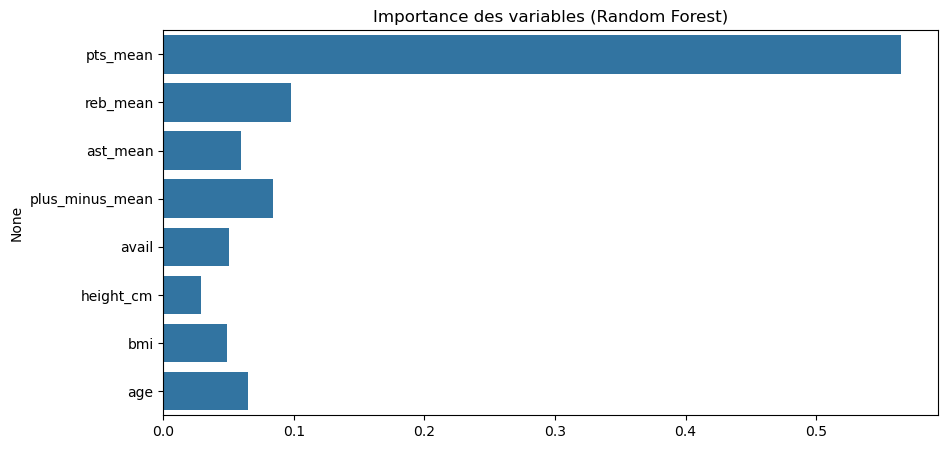

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_
features = X.columns

plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=features)
plt.title("Importance des variables (Random Forest)")
plt.show()